# Inspection Data Preprocessing

In [3]:
import pandas as pd
import numpy as np

In [23]:
dataset_csv = "../data/food-inspections.csv"

In [24]:
fi = pd.read_csv(dataset_csv)

## Dealing with NA values

`Inspection ID` is a reliable attribute to work with, e.g. for grouby counts, since there are no NAs:

In [25]:
fi['Inspection ID'].isna().any()

False

In [26]:
# There are no entries in these columns, we can drop them
empty_columns = fi.columns[fi[fi.notna()].count() == 0]
fi.drop(columns=empty_columns, inplace=True)

In [27]:
# Location column is redundant
fi[['Latitude', 'Longitude', 'Location']].head()

,Latitude,Longitude,Location
0,41.945065,-87.816734,"{'longitude': '41.945064857019986', 'latitude'..."
1,41.895692,-87.620143,"{'longitude': '41.895692401410514', 'latitude'..."
2,41.982582,-87.708996,"{'longitude': '41.98258181784537', 'latitude':..."
3,41.953378,-87.718848,"{'longitude': '41.95337788158545', 'latitude':..."
4,41.793235,-87.777776,"{'longitude': '41.7932347787373', 'latitude': ..."


In [28]:
fi.drop(columns='Location', inplace=True)

In [29]:
# Standardize empty strings to NANs https://stackoverflow.com/a/21942746
fi.replace(r'^\s*$', np.nan, inplace=True)

In [30]:
# Remove places from outside of Illinois
fi.drop(index=fi[(fi['State'].notna()) & (fi['State'] != 'IL')].index, inplace=True)

How many NA values we have in each column with some NA values:

In [31]:
# Remaining NA values
na_columns = fi.columns[fi.isna().any()]
len(fi) - fi[na_columns].count()

AKA Name            2450
License #             17
Facility Type       4776
Risk                  73
City                 139
State                 42
Zip                   51
Inspection Type        1
Violations         51782
Latitude             682
Longitude            682
dtype: int64

We should be bothered by missing: `License #` (possibly useful as place identifier), `Facility Type`, `Risk`?, `Zip`, `Inspection Type`? (only 1), geocoordinates

### `License #`

These were special events, churches, grocery store, so not included in our restaurant analysis, we can drop these rows

In [32]:
special_events = fi[fi['License #'].isna()].index
fi.drop(index=special_events, inplace=True)

In [33]:
# Rename license column for easier access
fi.rename(columns={'License #': 'License'}, inplace=True)

In [34]:
# We still have some suspicious license ids
# TODO: what to do with them?
fi[fi['License'] == 0.0]['Inspection ID'].count()

514

### `Facility Type`

Maybe we can get it from earlier inspections of the same place (same `License`)

In [35]:
na_facility_type_counts = fi[fi['Facility Type'].isna()].groupby(by=['License'])['Inspection ID'].count()

In [36]:
dba_names_for_na_facility = fi[fi['Facility Type'].isna()]['DBA Name'].unique()

In [37]:
total_na_facility_counts = fi[fi['DBA Name'].isin(dba_names_for_na_facility)].groupby(by=['License'])['Inspection ID'].count()

In [38]:
counts_diff = total_na_facility_counts - na_facility_type_counts

In [39]:
recoverable_licences = counts_diff[counts_diff > 0].index.values
recoverable_licences = recoverable_licences[recoverable_licences != 0]

In [40]:
# Obtain mapping from license to facility type
recovered = fi[fi['License'].isin(recoverable_licences)].groupby(by='License')['Facility Type'].unique().explode().dropna()

In [41]:
# Merge recovered facility types into fi
def take_not_nan(a, b):
    return b if pd.isna(a) else a

fi = fi.merge(recovered, how='left', left_on='License', right_index=True)
fi['Facility Type'] = fi['Facility Type_x'].combine(fi['Facility Type_y'], take_not_nan)
fi.drop(columns=['Facility Type_x', 'Facility Type_y'], inplace=True)

In [42]:
fi[fi['Facility Type'].isna()]['Inspection ID'].count()

4690

Managed to correct 86 records

### `Zip`
TODO: Process using Maja's solution

In [ ]:
# Making sure we are missing lat and long in same rows
(fi[fi['Latitude'].isna()].index == fi[fi['Longitude'].isna()].index).all()

In [ ]:
missing_location = fi[fi['Latitude'].isna()]
missing_location[['Address', 'City', 'State', 'Zip']].isna().any()

We have address for all of them, but we're missing zip codes for some

In [ ]:
missing_zip = missing_location[missing_location['Zip'].isna()]

In [ ]:
counts_by_state = fi.groupby(by='State')['Inspection ID'].count()
other_states = fi[fi['State'] != 'IL']

### Save results

In [45]:
fi.to_pickle('../data/fi_cleaned.pickle')

## Processing inspection types

In [3]:
import pandas as pd
import numpy as np

In [4]:
fi = pd.read_pickle('../data/fi_cleaned.pickle')

First limit to general notion of "restaurants":

In [5]:
fi.dropna(subset=['Facility Type'], inplace=True)
restaurants = fi[fi['Facility Type'].str.contains('restaurant', case=False)].copy()

In [6]:
unique_places_count = len(restaurants['License'].unique())
print('Number of unique places:', unique_places_count)
print('Avg. number of inspections per place: %.2f' % (float(len(restaurants)) / unique_places_count))

Number of unique places: 19925
Avg. number of inspections per place: 6.55


`Inspection Type` needs some cleaning. According to the document we should have following inspection types:
 - **canvass**: regular inspections with frequency depending on establishment risk,
 - **complaint**: in a response to filed complaint,
 - **license**: when obtaining a license, as a requirement of launching the establishment (should be once for most or more if they failed, this might be a separate study case),
 - **suspect food poisoning**: specific type of *complaint* when someone reports getting ill after eating from there
 - **task-force**: for bars and taverns.

Re-inspections can be done for most of the types and are indicated as well.

In [7]:
restaurants.fillna(value={'Inspection Type': 'Unknown'}, inplace=True)
inspection_types = restaurants['Inspection Type'].unique().astype(str)

In [8]:
inspection_types

array(['License', 'Canvass', 'Complaint', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Canvass Re-Inspection',
       'Recent Inspection', 'License Re-Inspection',
       'Suspected Food Poisoning',
       'Suspected Food Poisoning Re-inspection', 'Consultation',
       'Non-Inspection', 'Recent inspection', 'fire complaint', 'FIRE',
       'Tag Removal', 'Unknown', 'Not Ready', 'License-Task Force',
       'Complaint-Fire Re-inspection', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'KITCHEN CLOSED FOR RENOVATION',
       'CORRECTIVE ACTION', 'LICENSE CANCELED BY OWNER',
       'Task Force Liquor 1475', 'TWO PEOPLE ATE AND GOT SICK.',
       'Pre-License Consultation', 'CANVASS SPECIAL EVENTS',
       'OUT OF BUSINESS', 'No entry', 'NO ENTRY', 'Package Liquor 1474',
       'Sample Collection', 'FIRE/COMPLAIN', '1315 license reinspection',
       'Task Force Liquor Catering', 'SFP', 'CANVAS', 'no entry',
       'SFP/COMPLAINT', 'SFP/Complaint', 'Special Events (Fe

First set `Re-inspection` flag column:

In [9]:
reinspection_pattern = 're-inspec|reinspec|re inspec'
restaurants['Re-inspection'] = restaurants['Inspection Type'].str.lower().str.contains(reinspection_pattern, regex=True)

In [10]:
inspection_types_lower = np.char.lower(inspection_types)

Standardize **cavass**:

In [11]:
canvass_values = inspection_types[np.char.find(inspection_types_lower, 'canvas') != -1]
restaurants.replace(to_replace=canvass_values, value='Canvass', inplace=True)

Standardize **complaint**:

In [12]:
complaint_values = inspection_types[np.char.find(inspection_types_lower, 'complain') != -1]
restaurants.replace(to_replace=complaint_values, value='Complaint', inplace=True)

Standardize **license**:

In [13]:
license_values = inspection_types[np.char.find(inspection_types_lower, 'license') != -1]
restaurants.replace(to_replace=license_values, value='License', inplace=True)

Standardize **suspect food poisoning**:

In [14]:
sfp_values = restaurants['Inspection Type'].str.lower().str.contains('food|sfp', regex=True)
restaurants.loc[sfp_values, 'Inspection Type'] = 'Suspected Food Poisoning'

Standardize **task force**:

In [15]:
taskforce_values = inspection_types[np.char.find(inspection_types_lower, 'task') != -1]
liquor_values = inspection_types[np.char.find(inspection_types_lower, 'liquor') != -1]
restaurants.replace(to_replace=np.append(taskforce_values, liquor_values), value='Task Force', inplace=True)

Special standardization:

In [16]:
sick_values = inspection_types[np.char.find(inspection_types_lower, 'sick') != -1]
restaurants.replace(to_replace=sick_values, value='Suspect Food Poisoning', inplace=True)

In [17]:
restaurants['Inspection Type'].unique()

array(['License', 'Canvass', 'Complaint', 'Recent Inspection',
       'Suspected Food Poisoning', 'Consultation', 'Non-Inspection',
       'Recent inspection', 'FIRE', 'Tag Removal', 'Unknown', 'Not Ready',
       'KITCHEN CLOSED FOR RENOVATION', 'CORRECTIVE ACTION', 'Task Force',
       'Suspect Food Poisoning', 'OUT OF BUSINESS', 'No entry',
       'NO ENTRY', 'Sample Collection', 'no entry',
       'Special Events (Festivals)', 'expansion', 'error save',
       'CHANGED COURT DATE', 'No Entry', 'Out of Business',
       'citation re-issued', 'TASTE OF CHICAGO', 'HACCP QUESTIONAIRE',
       'RE-INSPECTION OF CLOSE-UP', 'REINSPECTION', 'POSSIBLE FBI'],
      dtype=object)

In [18]:
# Move out of business indication to the right column
out_of_business = restaurants[restaurants['Inspection Type'].str.lower().str.contains('business')].index
restaurants.loc[out_of_business, 'Results'] = 'Out of Business'

In [19]:
restaurants.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
CHANGED COURT DATE                   1
CORRECTIVE ACTION                    1
Canvass                          83592
Complaint                        25041
Consultation                       396
FIRE                                 1
HACCP QUESTIONAIRE                   1
KITCHEN CLOSED FOR RENOVATION        1
License                          19460
NO ENTRY                             5
No Entry                            48
No entry                             1
Non-Inspection                       9
Not Ready                            7
OUT OF BUSINESS                     11
Out of Business                     52
POSSIBLE FBI                         1
RE-INSPECTION OF CLOSE-UP            1
REINSPECTION                         1
Recent Inspection                  229
Recent inspection                    2
Sample Collection                    1
Special Events (Festivals)          20
Suspect Food Poisoning               1
Suspected Food Poisoning           918
TASTE OF 

We should remain `Tag Removal`, `Recent Inspection` (unite), `Out of Business` (unite), `No entry` (unite) and `Consultation`. All of the rest we classify as `Unknown`.

In [20]:
recent_inspections = restaurants['Inspection Type'].str.lower().str.contains('recent inspection')
restaurants.loc[recent_inspections, 'Inspection Type'] = 'Recent Inspection'

In [21]:
out_of_business_inspections = restaurants['Inspection Type'].str.lower().str.contains('out of business')
restaurants.loc[out_of_business_inspections, 'Inspection Type'] = 'Out of Business'

In [22]:
no_entry_inspections = restaurants['Inspection Type'].str.lower().str.contains('no entry')
restaurants.loc[no_entry_inspections, 'Inspection Type'] = 'No Entry'

In [23]:
known_list = ['License', 'Canvass', 'Complaint', 'Consultation', 'No Entry', 'Out of Business', 'Recent Inspection', 'Suspected Food Poisoning', 'Tag Removal', 'Task Force']
restaurants.loc[~restaurants['Inspection Type'].isin(known_list), 'Inspection Type'] = 'Unknown'

In [24]:
restaurants.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
Canvass                     83592
Complaint                   25041
Consultation                  396
License                     19460
No Entry                       56
Out of Business                63
Recent Inspection             231
Suspected Food Poisoning      918
Tag Removal                   484
Task Force                    226
Unknown                        51
Name: Inspection ID, dtype: int64

TODO: We might want to standardize further, e.g. unite Consulatation with Canvass of License etc. or treat Unknowns with more details.

In [26]:
pd.to_pickle(restaurants, '../data/restaurants.pickle')

## Further preprocessing

In [1]:
import pandas as pd
import numpy as np

In [25]:
restaurants = pd.read_pickle('../data/restaurants.pickle')

In [26]:
restaurants.groupby(by='Risk')['Inspection ID'].count()

Risk
All                    10
Risk 1 (High)      104758
Risk 2 (Medium)     24400
Risk 3 (Low)         1335
Name: Inspection ID, dtype: int64

In [27]:
# TODO: instead of dropping, fill it with Maja's method
restaurants.dropna(subset=['Zip'], inplace=True)

In [28]:
restaurants['Zip'] = restaurants['Zip'].apply(lambda zip_code: str(int(zip_code)))

## Violations

In [91]:
import matplotlib.pyplot as plt

In [46]:
restaurants.fillna(value={'Violations': ''}, inplace=True)

In [64]:
def extract_violation_codes(violation):
    violations_list = list(map(lambda v: v.strip(), violation.split('|')))
    violation_dots = [v.find('.') for v in violations_list]
    violation_codes = [int(v[:idx]) for v, idx in zip(violations_list, violation_dots) if idx != -1 ]
    return violation_codes

In [66]:
restaurants['Violation Codes'] = restaurants['Violations'].apply(extract_violation_codes)

In [201]:
def merge_violation_codes(violation_series):
    return [code for inspection_violation_codes in violation_series.values for code in inspection_violation_codes]

def violation_counts(violations):
    counts, code_bins = np.histogram(violations, bins=np.arange(1, 72))  # violations can take codes from 1 to 70
    return counts, code_bins

def violations_distribution(df):
    # https://stackoverflow.com/a/38258158
    all_codes = merge_violation_codes(df['Violation Codes'])
    counts, code_bins = violation_counts(all_codes)
    return code_bins[:-1], counts

### Most common violations in general:

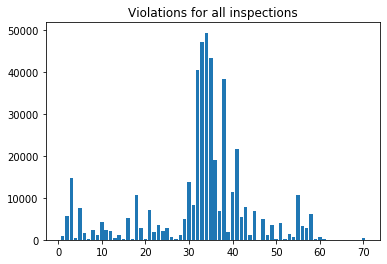

In [202]:
plt.bar(*violations_distribution(restaurants))
plt.title('Violations for all inspections')
plt.show()

### Most common violations for fail:

In [203]:
failed_inspections = restaurants[restaurants['Results'] == 'Fail']

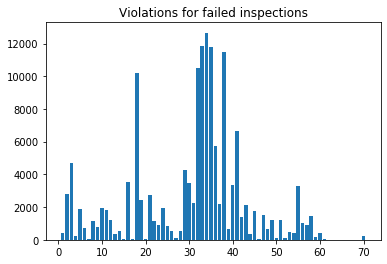

In [204]:
plt.bar(*violations_distribution(failed_inspections))
plt.title('Violations for failed inspections')
plt.show()

### Most common violation for pass with conditions:

In [205]:
pass_with_conditions_inspections = restaurants[restaurants['Results'] == 'Pass w/ Conditions']

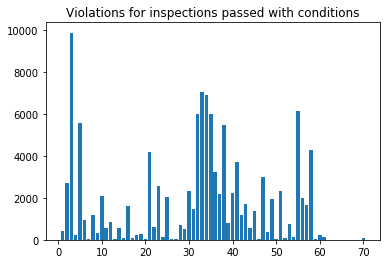

In [206]:
plt.bar(*violations_distribution(pass_with_conditions_inspections))
plt.title('Violations for inspections passed with conditions')
plt.show()

### Violations by neighbourhood

In [207]:
def violation_codes_by_neighbourhood(df):
    return df.groupby(by='Zip')['Violation Codes'].apply(merge_violation_codes)

Most common violation in each neighbourhood:

In [215]:
def most_common_violations(violations, top=1):
    counts, _ = violation_counts(violations)
    return np.argsort(counts)[::-1][:top] + 1  # add one to conver to violation code from index

In [218]:
most_common = violation_codes_by_neighbourhood(restaurants).apply(most_common_violations, top=3)

In [219]:
most_common_for_fail = violation_codes_by_neighbourhood(failed_inspections).apply(most_common_violations, top=3)

### Notes:

There are sometimes same violation codes in one inspection (probably multiple violations to same criterion). Should we count them only once per inspection or as many times as they appear (as currently)?

### (Informational) Violation descriptions

In [232]:
def violation_descriptions(violations):
    violations_list = list(map(lambda violation: violation.strip(), violations.split('|')))
    violation_name_end_indices = [violation.find(' - Comments:') for violation in violations_list]
    return set([violation[:idx] for violation, idx in zip(violations_list, violation_name_end_indices) if idx != -1])

In [236]:
def all_violation_descriptions(df):
    violation_description_sets = df['Violations'].apply(violation_descriptions).values
    descriptions = set().union(*violation_description_sets)  # https://stackoverflow.com/a/31253153

In [237]:
descriptions

{'1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES',
 '1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PROPERLY LABELED, SHELLFISH TAGS IN PLACE',
 '10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
 '10. SEWAGE AND WASTE WATER DISPOSAL, NO BACK SIPHONAGE, CROSS  CONNECTION AND/OR BACK FLOW',
 '11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED',
 '11. FOOD OBTAINED FROM APPROVED SOURCE',
 '12. FOOD RECEIVED AT PROPER TEMPERATURE',
 '12. HAND WASHING FACILITIES: WITH SOAP AND SANITARY HAND DRYING DEVICES, CONVENIENT AND ACCESSIBLE TO FOOD PREP AREA',
 '13. FOOD IN GOOD CONDITION, SAFE, & UNADULTERATED',
 '13. NO EVIDENCE OF RODENT OR INSECT INFESTATION, NO BIRDS, TURTLES OR OTHER ANIMALS',
 '14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42-090',
 '14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAGS, PARASITE DESTRUCTION',
 '15. FOOD SEPARATED AND PROTECTED',
 '15. UNWRAPPED AND POTENTIALLY HAZARDOUS FOOD NOT RE-SERVED',
 '16. FOOD PROT

According to [this page](http://dev.cityofchicago.org/open%20data/data%20portal/2018/06/29/food-violations-changes.html) linked to the dataset, violations change on the 1/07/2018. It might be useful then to analyze descriptions (and violations) for these two periods separately.